In [60]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [61]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from imblearn.over_sampling import SMOTE

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score

In [62]:
# load data
df = pd.read_csv('../../data/H2.csv')

In [63]:
# Handle missing values
df["Children"].fillna(0, inplace=True)  # Fill missing 'Children' with 0
df["Country"].fillna("Unknown", inplace=True)  # Fill missing 'Country' with 'Unknown'

# Drop rows where adults, babies and children are zero at the same time
df = df[(df["Adults"] != 0) | (df["Babies"] != 0) | (df["Children"] != 0)]

In [ ]:
# Drop Duplicate rows
print(f"Total Number of Rows: {len(df)}")
print(f"Total Number of Rows without Duplicates: {len(df.drop_duplicates())}")

df = df.drop_duplicates()

Total Number of Rows: 79163
Total Number of Rows without Duplicates: 53274


In [65]:
# Remove Outliers
# Get only numerical data
df_num = df.select_dtypes(include=[np.number])
# Get only Categorical data
df_cat = df.select_dtypes(include=["object"])

df_num_out = df_num[["LeadTime", "ADR"]]

# Outlier Detection Fonksion
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2.5 * IQR
    upper_bound = Q3 + 2.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Remove Outliers
def remove_outliers(data, outliers):
  return data.drop(outliers.index)

for col in df_num_out:
  outliers = detect_outliers_iqr(df, col)
  df = remove_outliers(df, outliers)
  print(f"{col}: {len(outliers)} outliers removed.")

df.shape

LeadTime: 351 outliers removed.
ADR: 254 outliers removed.


(52669, 31)

In [66]:
# Remove Directly Related columns with label
df = df.drop(["ReservationStatus", "ReservationStatusDate", "AssignedRoomType"], axis=1)

In [67]:
# Remove Unimportant Variables
corr_matrix = df.select_dtypes(include=[np.number]).corr()
corr_matrix["IsCanceled"].abs().sort_values(ascending=False)

IsCanceled                     1.000000
LeadTime                       0.191161
TotalOfSpecialRequests         0.161334
RequiredCarParkingSpaces       0.125098
StaysInWeekNights              0.116383
ADR                            0.100196
BookingChanges                 0.090958
Adults                         0.084656
ArrivalDateYear                0.083995
IsRepeatedGuest                0.073327
StaysInWeekendNights           0.066643
PreviousBookingsNotCanceled    0.048569
PreviousCancellations          0.039456
Children                       0.036668
Babies                         0.021196
ArrivalDateWeekNumber          0.009831
DaysInWaitingList              0.004596
ArrivalDateDayOfMonth          0.003705
Name: IsCanceled, dtype: float64

In [68]:
df = df.drop(
    [
        "ArrivalDateDayOfMonth",
        "ArrivalDateWeekNumber",
    ],
    axis=1,
)

In [69]:
# Define a dictionary to map country codes to regions
country_to_region = {
    "PRT": "Europe",
    "GBR": "Europe",
    "ESP": "Europe",
    "IRL": "Europe",
    "NLD": "Europe",
    "RUS": "Europe",
    "FRA": "Europe",
    "DEU": "Europe",
    "ITA": "Europe",
    "BEL": "Europe",
    "CHE": "Europe",
    "USA": "North America",
    "CAN": "North America",
    "MEX": "North America",
    "CN": "Asia",
    "BRA": "South America",
    "ARG": "South America",
    "AUS": "Oceania",
    "Unknown": "Unknown",
}

# Map the country codes to regions
df["Region"] = df["Country"].map(country_to_region)

# Drop the Country column
df.drop(columns=["Country"], inplace=True)

df["Region"].value_counts()

Region
Europe           41174
South America     1726
North America     1456
Asia               484
Oceania            264
Unknown              3
Name: count, dtype: int64

In [70]:
# Remove blank spaces from the 'Agent' column
df['Agent'] = df['Agent'].str.strip()

# Replace 'NULL' values in the 'Agent' column with 0
df['Agent'].replace('NULL', 0, inplace=True)

# Convert the 'Agent' column to integer
df['Agent'] = df['Agent'].astype(int)

df['Agent'].value_counts()

Agent
9      28624
0       5514
7       3287
14      3272
28      1488
       ...  
388        1
480        1
464        1
476        1
449        1
Name: count, Length: 223, dtype: int64

In [71]:
# Remove blank spaces from the 'Agent' column
df['Company'] = df['Company'].str.strip()

# Replace 'NULL' values in the 'Agent' column with 0
df['Company'].replace('NULL', 0, inplace=True)

# Convert the 'Agent' column to integer
df['Company'] = df['Company'].astype(int)

df['Company'].value_counts()

Company
0      49908
40       845
45       237
153      205
219      131
       ...  
481        1
494        1
491        1
421        1
497        1
Name: count, Length: 203, dtype: int64

In [72]:
from sklearn.model_selection import train_test_split

# Split data to features and target
X = df.drop("IsCanceled", axis=1)
y = df["IsCanceled"]

# Stratified splitting into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True
)

# Check the resulting split sizes and class distribution in both sets
train_size = X_train.shape[0]
test_size = X_test.shape[0]
train_class_distribution = y_train.value_counts(normalize=True)
test_class_distribution = y_test.value_counts(normalize=True)

train_size, test_size, train_class_distribution, test_class_distribution

(42135,
 10534,
 IsCanceled
 0    0.700534
 1    0.299466
 Name: proportion, dtype: float64,
 IsCanceled
 0    0.700589
 1    0.299411
 Name: proportion, dtype: float64)

In [24]:
# Custom transformers for feature engineering
def add_group_type(data):
    def determine_group_type(row):
        if row["Adults"] == 1 and (row["Children"] + row["Babies"] == 0):
            return "Single"
        elif row["Adults"] == 2 and (row["Children"] + row["Babies"] == 0):
            return "Couple"
        elif (row["Children"] + row["Babies"]) > 0:
            return "Family"
        elif row["Adults"] > 2:
            return "Big_Group"
        else:
            return "Other"

    data["GroupType"] = data.apply(determine_group_type, axis=1)
    return data


def add_booking_urgency(data):
    def determine_booking_urgency(lead_time):
        if lead_time > 60:
            return "Early_Booking"
        elif 30 <= lead_time <= 60:
            return "Medium_Term_Booking"
        else:
            return "Last_Minute_Booking"

    data["BookingUrgency"] = data["LeadTime"].apply(determine_booking_urgency)
    return data


def add_high_demand(data):
    data["HighDemand"] = data["TotalOfSpecialRequests"].apply(
        lambda x: "High" if x >= 2 else "Low"
    )
    return data


def add_child_ratio(data):
    data["ChildRatio"] = (data["Children"] + data["Babies"]) / (
        data["Adults"] + data["Children"] + data["Babies"]
    )
    data["ChildRatio"].fillna(0, inplace=True)
    return data


def add_waiting_time_category(data):
    def determine_waiting_time_category(days):
        if days < 7:
            return "Short"
        elif 7 <= days <= 30:
            return "Medium"
        else:
            return "Long"

    data["WaitingTimeCategory"] = data["DaysInWaitingList"].apply(
        determine_waiting_time_category
    )
    return data


# Pipeline for feature engineering
feature_engineering_pipeline = Pipeline(
    steps=[
        ("add_group_type", FunctionTransformer(add_group_type)),
        ("add_booking_urgency", FunctionTransformer(add_booking_urgency)),
        ("add_high_demand", FunctionTransformer(add_high_demand)),
        ("add_child_ratio", FunctionTransformer(add_child_ratio)),
        ("add_waiting_time_category", FunctionTransformer(add_waiting_time_category))
    ]
)

# Categoric and Numeric features
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Final pipeline with feature engineering, preprocessing
final_pipeline = Pipeline(
    steps=[
        ("feature_engineering", feature_engineering_pipeline),
        ("preprocessing", preprocessor),
    ]
)

In [25]:
# Instantiate the classifier
rf = RandomForestClassifier(random_state=42)

rf_pipeline = Pipeline(
    steps=[
        ("preprocessing", final_pipeline),
        ("classifier", rf),
    ]
)

rf_pipeline.fit(X_train, y_train)

# Predict the labels
y_pred = rf_pipeline.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8052022023922537

In [26]:
# Instantiate the classifier
rf = RandomForestClassifier(random_state=42)

rf_pipeline = Pipeline(
    steps=[
        ("preprocessing", final_pipeline),
        ("classifier", rf),
    ]
)

rf_pipeline.fit(X_train, y_train)

# Predict the labels
y_pred = rf_pipeline.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8052022023922537

In [27]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[6664,  716],
       [1336, 1818]])

In [28]:
# Generate the classification report
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.83      0.90      0.87      7380
           1       0.72      0.58      0.64      3154

    accuracy                           0.81     10534
   macro avg       0.78      0.74      0.75     10534
weighted avg       0.80      0.81      0.80     10534



In [29]:
# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
roc_auc

np.float64(0.7396959682976665)

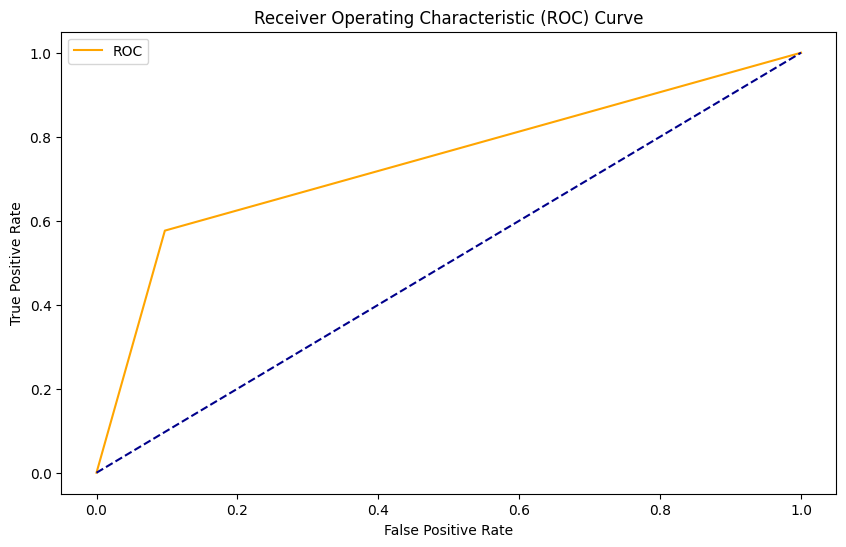

In [30]:
# Calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_test, y_pred)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [31]:
# Perform 5-fold cross validation
cv_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=5, scoring='accuracy')

# Calculate the mean accuracy
cv_mean = cv_scores.mean()
cv_mean

# Calculate the standard deviation of accuracy
cv_std = cv_scores.std()
cv_std

print(f"Cross Validation Scores:\n{cv_scores}")
print(f"Mean: {cv_mean:.4f} / Std: {cv_std:.4f}")

Cross Validation Scores:
[0.7925715  0.80348879 0.79850481 0.79660615 0.79565682]
Mean: 0.7974 +/- Std: 0.0036
